## Automated anisotropic resistivity inversion for efficient formation evaluation and uncertainty quantification

### Misael M. Morales, Ali Eghbali, Oriyomi Raheem, Michael Pyrcz, Carlos Torres-Verdin
***
## Machine Learning-based Inversion
***

In [31]:
from main import *

check_torch()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
case1, case2, synthetic1, synthetic2 = load_all_data()


------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.2.2+cu121 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080
------------------------------------------------------------

Field Case 1: (2399, 7)
Field Case 2: (11143, 7)
Synthetic Case 1: (801, 10)
Synthetic Case 2: (415, 6)


***
### Physics-informed neural network inversion

In [43]:
class ResInvLoss(nn.Module):
    def __init__(self, Rvsh=10, Rhsh=1, lambda_reg=1e-5, lambda_p=2):
        super(ResInvLoss, self).__init__()
        self.lambda_reg = lambda_reg
        self.lambda_p = lambda_p
        self.Rvsh = Rvsh
        self.Rhsh = Rhsh

    def forward(self, inputs, outputs):
        Rv_true = inputs[:, 0]
        Rh_true = inputs[:, 1]

        Csh_pred = outputs[:, 0]
        Rss_pred = outputs[:, 1]

        eq1 = (Csh_pred*self.Rvsh + (1-Csh_pred)*Rss_pred) - (Rv_true)
        eq2 = 1/(Csh_pred/self.Rhsh + (1-Csh_pred)/Rss_pred) - (Rh_true)
        eqs = torch.stack([eq1, eq2], dim=-1)

        wd1, wd2 = 1/Rv_true, 1*Rh_true
        Wdm = torch.stack([wd1, wd2], dim=-1)

        costf = torch.norm(torch.matmul(Wdm.T, eqs), p=2)
        regPa = self.lambda_reg*torch.norm(outputs, p=self.lambda_p)

        return  costf + regPa

In [32]:
class ResInvPINN(nn.Module):
    def __init__(self):
        super(ResInvPINN, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 2)

    def constraints(self, x):
        c, s = x[:, 0], x[:, 1]
        c = nn.Sigmoid()(c)
        return torch.stack([c, s], dim=-1)
       
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.constraints(x)
        return x

In [41]:
w1_keys = ['CALI', 'AT10','AT30','AT60','AT90','GR','RV72H_1D_FLT','RH72H_1D_FLT']
d = lasio.read('cases/well1.las').df()[w1_keys].dropna()
column_names = ['CALI', 'AT10', 'AT30', 'AT60', 'AT90', 'GR', 'Rv', 'Rh']

zstart = int(np.argwhere(d.index==9720).squeeze())
zend   = int(np.argwhere(d.index==10110).squeeze())

data      = d.rename(columns=dict(zip(d.columns, column_names))).iloc[zstart:zend]
res_aniso = data[['Rv', 'Rh']]

Rvsh_true = 2.813
Rhsh_true = 0.775

inputs = torch.tensor(res_aniso.values, dtype=torch.float32).to(device)
print('Inputs: {}'.format(inputs.shape))

Inputs: torch.Size([1560, 2])


In [44]:
dataset        = TensorDataset(inputs)
train_percent  = 0.8
xtrain, xvalid = random_split(dataset, [int(train_percent*len(dataset)), len(dataset)-int(train_percent*len(dataset))])
print('X_train: {} | X_valid: {}'.format(len(xtrain), len(xvalid)))

batch_size  = 32
trainloader = DataLoader(xtrain, batch_size=batch_size, shuffle=True)
validloader = DataLoader(xvalid, batch_size=batch_size, shuffle=True)

pinn       = ResInvPINN().to(device)
criterion  = ResInvLoss(Rvsh=Rvsh_true, Rhsh=Rhsh_true, lambda_reg=1e-5, lambda_p=1).to(device)
optimizer  = torch.optim.Adam(params=pinn.parameters(), lr=1e-3)

X_train: 1248 | X_valid: 312


X_train: 1248 | X_valid: 312
Epoch: 0 | Loss: 316.8303 | Valid Loss: 177.3889
Epoch: 100 | Loss: 20.7368 | Valid Loss: 17.7118
Epoch: 200 | Loss: 28.4374 | Valid Loss: 32.7392
Epoch: 300 | Loss: 19.0360 | Valid Loss: 22.1844


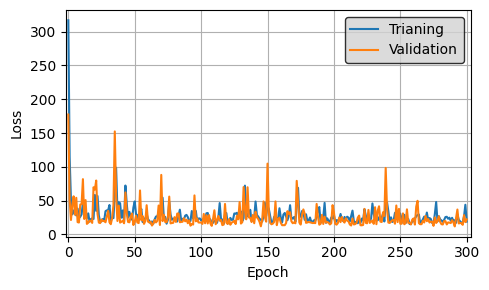

In [42]:
epochs, monitor = 301, 100
train_loss, valid_loss = [], []
for epoch in range(epochs):
    # training
    epoch_train_loss = []
    pinn.train()
    for i, x in enumerate(trainloader):
        optimizer.zero_grad()
        y = pinn(x[0])
        loss = criterion(x[0], y)
        loss.backward()
        optimizer.step()
        epoch_train_loss.append(loss.item())
    train_loss.append(np.mean(epoch_train_loss))
    # validation
    pinn.eval()
    epoch_valid_loss = []
    with torch.no_grad():
        for x in validloader:
            y = pinn(x[0])
            loss = criterion(x[0], y)
            epoch_valid_loss.append(loss.item())
        valid_loss.append(np.mean(epoch_valid_loss))
    # progress
    if epoch % monitor == 0:
        print('Epoch: {} | Loss: {:.4f} | Valid Loss: {:.4f}'.format(epoch, train_loss[-1], valid_loss[-1]))
losses = (train_loss, valid_loss)
plot_loss(losses)

In [39]:
y_pred = pinn(inputs[:,:2]).cpu().detach().numpy().squeeze()
Csh_pred, Rss_pred = [y_pred[:, i] for i in range(y_pred.shape[1])]
print('Csh: min={:.3f} | max={:.3f}'.format(Csh_pred.min(), Csh_pred.max()))

Rv_true = res_aniso['Rv'].values
Rh_true = res_aniso['Rh'].values

Rv_sim = (Csh_pred*Rvsh_true + (1-Csh_pred)*Rss_pred)
Rh_sim = 1/(Csh_pred/Rhsh_true + (1-Csh_pred)/Rss_pred)

Rv_err = np.abs((Rv_sim - Rv_true)/Rv_true) * 100
Rh_err = np.abs((Rh_sim - Rh_true)/Rh_true) * 100

pinn_sol = pd.DataFrame({'Csh_pred':Csh_pred, 'Rss_pred':Rss_pred, 
                         'Rvsh':Rhsh_true, 'Rhsh':Rhsh_true,
                         'Rv_sim':Rv_sim, 'Rh_sim':Rh_sim,
                         'Rv_err':Rv_err, 'Rh_err':Rh_err}, index=res_aniso.index)

results = pd.concat([data, pinn_sol], axis=1)
results.to_csv('pinn_solution.csv', index=True)

error_metrics(results)

Csh: min=0.073 | max=0.344
Mean Squared Error - Rv: 0.5033  | Rh: 0.4749
R2 Score           - Rv: 98.748  | Rh: 35.603
Standard Error     - Rv: 0.8159  | Rh: 1.4365
Percentage Error   - Rv: 23.5004% | Rh: 54.7310%


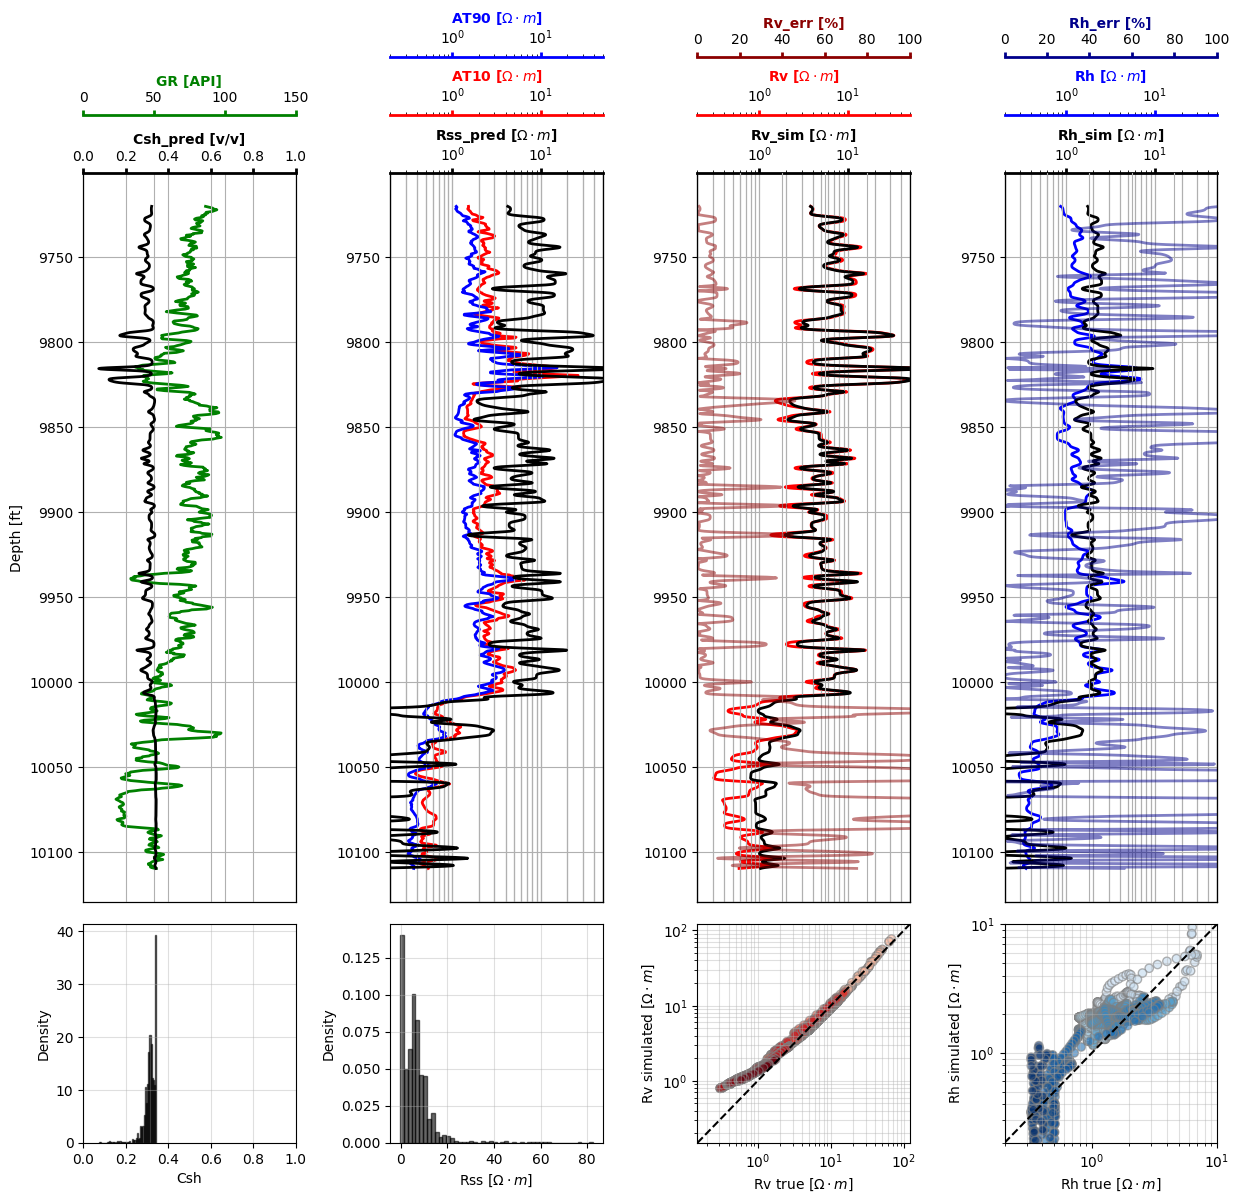

In [40]:
plot_pinn_results(results, figsize=(12.5,12))

In [ ]:
gradientbased_results = pd.read_csv('results/gradient_based_solution_Chevron.csv', index_col=0)
plot_pinn_gb_comparison(results, gradientbased_results, figsize=(12.5,12))

***
# END